In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [2]:
# Download data from open datasets. https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
sat_data = datasets.EuroSAT(
    root="data",
    download=True,
    transform=ToTensor(),
)
print(f"There are {len(sat_data)} images in this data set")

There are 27000 images in this data set


In [3]:
#here are the classes
class_labels = sat_data.find_classes('data/eurosat/2750/')[0]

In [4]:
#label dictionary (taken from Kaggle link above)
label2int= sat_data.find_classes('data/eurosat/2750/')[1]
int2label = dict(zip(label2int.values(),label2int.keys()))

In [5]:
train_size =.8
test_size = .2
torch.manual_seed(0)
train_size = round(.8*len(sat_data))
training_data, testing_data = torch.utils.data.random_split(sat_data, [train_size, len(sat_data)-train_size])

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


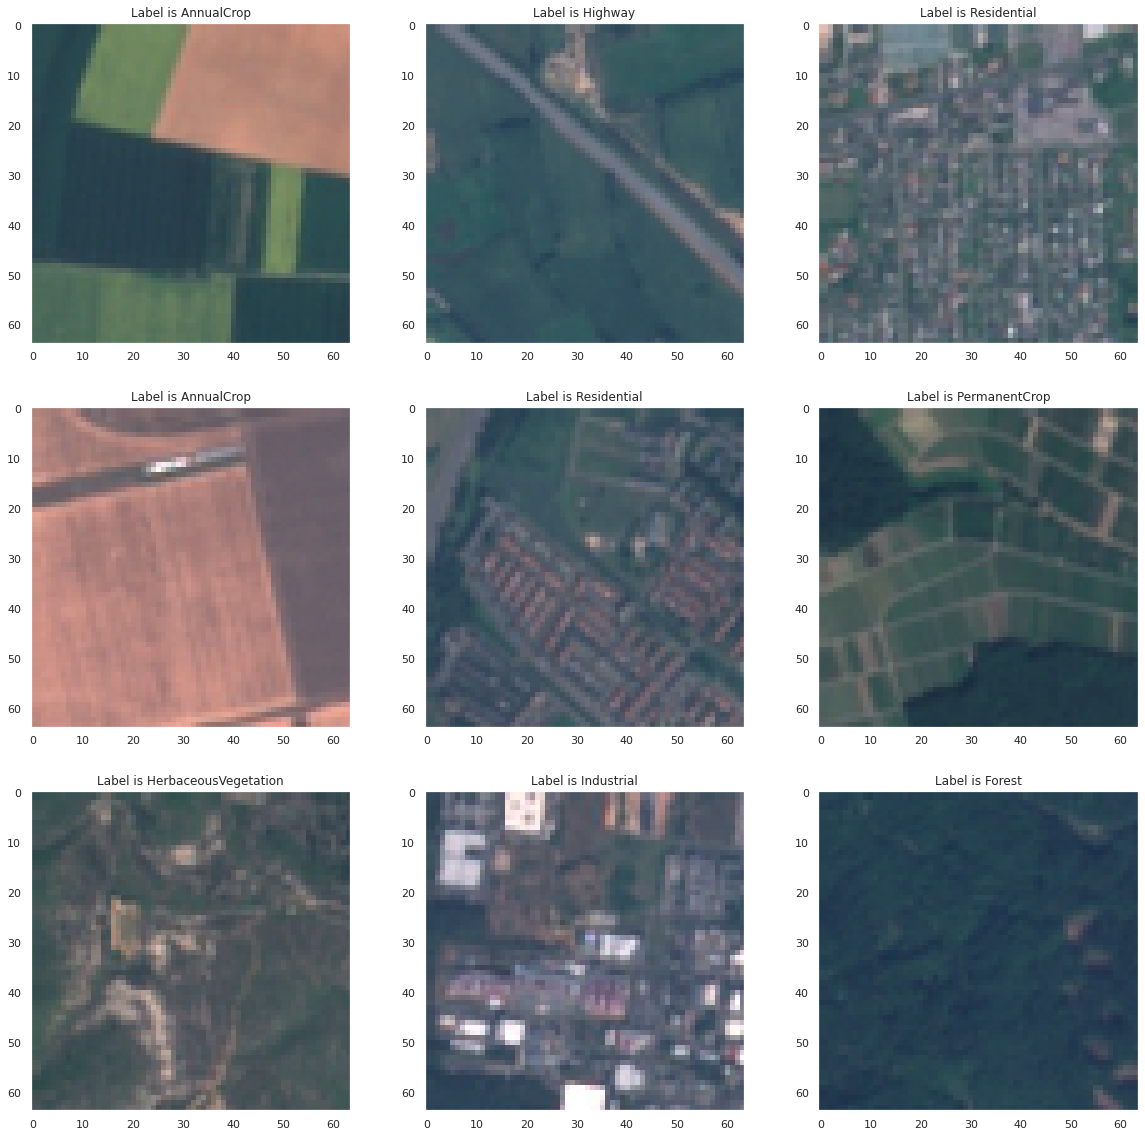

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

cols, rows = 3, 3
figure = plt.figure(figsize=(20, 20))
for X, y in test_dataloader:
    for i in range(1, cols*rows + 1): #show 10 images and their labels
        figure.add_subplot(rows, cols, i)
        plt.title(f"Label is {int2label[y[i].item()]}")
        plt.imshow(X[i,:,:,:].permute(1, 2, 0))
        plt.grid(False)
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
plt.show()

In [7]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv_net_stack = nn.Sequential(
            nn.Conv2d(3, 12, (3, 3), 1), #in channels, out channels, kernel size, stride
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(12, 10, (3, 3), 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Flatten(),
            nn.Linear(1960, 100), #(w x h x c, output_dim)
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        logits = self.conv_net_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv_net_stack): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1960, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=50, bias=True)
    (10): ReLU()
    (11): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [8]:
?nn.MaxPool2d

Init signature:
nn.MaxPool2d(
    kernel_size: Union[int, Tuple[int, ...]],
    stride: Union[int, Tuple[int, ...], NoneType] = None,
    padding: Union[int, Tuple[int, ...]] = 0,
    dilation: Union[int, Tuple[int, ...]] = 1,
    return_indices: bool = False,
    ceil_mode: bool = False,
) -> None
Docstring:     
Applies a 2D max pooling over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
can be precisely described as:

.. math::
    \begin{aligned}
        out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
                                & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
                                               \text{stride[1]} \times w + n)
    \end{aligned}

If :attr:`padding` is non-zero, then the input is implicitly padded with negative infinity on both

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
torch.manual_seed(0)
epochs = 200
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")

Epoch 1
-------------------------------
loss: 2.298068  [    0/21600]
loss: 2.297396  [ 6400/21600]
loss: 2.312820  [12800/21600]
loss: 2.293374  [19200/21600]
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.303639 

Epoch ran in 8.30 seconds
Epoch 2
-------------------------------
loss: 2.296815  [    0/21600]
loss: 2.297851  [ 6400/21600]
loss: 2.309273  [12800/21600]
loss: 2.291797  [19200/21600]
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.301669 

Epoch ran in 8.31 seconds
Epoch 3
-------------------------------
loss: 2.295729  [    0/21600]
loss: 2.297962  [ 6400/21600]
loss: 2.305991  [12800/21600]
loss: 2.290390  [19200/21600]
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.299999 

Epoch ran in 8.01 seconds
Epoch 4
-------------------------------
loss: 2.295292  [    0/21600]
loss: 2.297976  [ 6400/21600]
loss: 2.303177  [12800/21600]
loss: 2.289029  [19200/21600]
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.298380 

Epoch ran in 8.20 seconds
Epoch 5
-------------------------------
loss: 2.

In [13]:
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for X,y in test_dataloader:
        X.to(device)
        test_predictions += [model(X.to(device)).argmax(1)]
        test_labels += [y]
test_predictions = torch.cat(test_predictions)
test_labels = torch.cat(test_labels)

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
c_mat = confusion_matrix(test_labels, test_predictions.cpu())

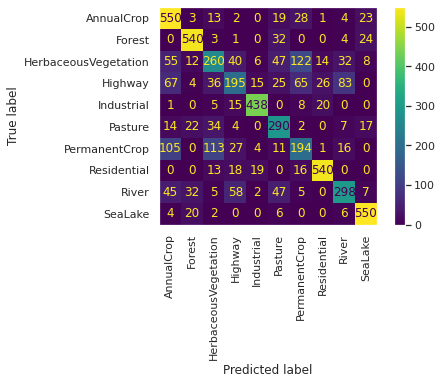

In [16]:
ConfusionMatrixDisplay(c_mat, display_labels=class_labels).plot(xticks_rotation='vertical')
ax = plt.gca()
ax.grid(False)
plt.show()